# Speech Recognition  

- This project is to detect the 5 following 1 second voice commands sampled at 16000 Hz :

- bed, bird, cat, dog, down

#### Data

- The training data is provided by the Google Brain challenge named: TensorFlow Speech Recognition Challenge and contains around 9300 samples of the 5 voice commands mentioned above. The data is gathered by thousands of volunteers across the world. Also, there have been sample noises provided which were randomly selected and added to the train and validation sets to make the train and validation more real world like scenarios. The data used here is a sample of the original dataset from https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge/data

- The original data has 23k samples of the 10 voice commands and a total of 64721 utterances in total. In addition to the command voices, there are 20 other word utterances to be used as sample other words that might be mentioned and need to be categorized as unknown words. 

In [ ]:
# Install required libraries
!pip3 install pyunpack
!pip3 install patool
!pip3 install py7zr
!pip3 install sounddevice
!pip3 install noisereduce
!pip3 install librosa
!pip3 install python_speech_features
!pip3 install webrtcvad

# If using conda, then try to install librosa in two steps - Install both step 1 & 2
# 1. conda install -c numba numba
# 2. conda install -c conda-forge librosa

In [ ]:
# Initialize required libraries

import numpy as np                        # linear algebra library
import pandas as pd                       # data frames processing
import matplotlib.pyplot as plt           # visualization library
import seaborn as sns                      # visualization library

# audio processing library
import librosa                          
import IPython.display as ipd            
from scipy.io import wavfile
import noisereduce as nr
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder 

#operating system libraries
import shutil
import warnings
warnings.filterwarnings("ignore")
import tensorflow 
import os

In [ ]:
# Set the train audio path
train_audio_path = 'train_data'

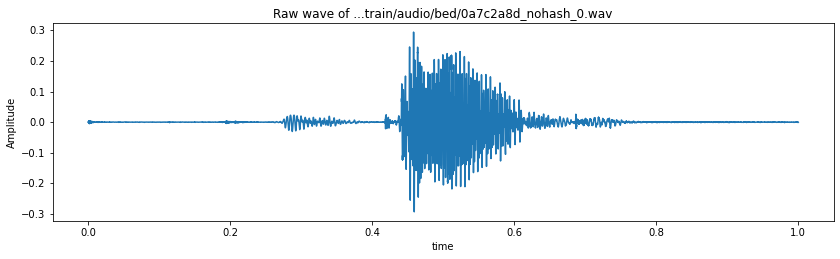

In [ ]:
# Visualization of Audio signals in time series domain

samples, sample_rate = librosa.load(train_audio_path+'/bed/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '...train/audio/bed/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

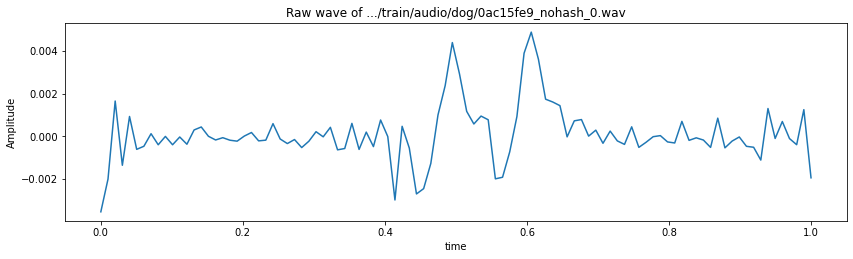

In [ ]:
# Another sample of audio signal with different sampling rate

samples, sample_rate = librosa.load(train_audio_path+'/dog/0ac15fe9_nohash_0.wav', sr = 100)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '.../train/audio/dog/0ac15fe9_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

#### Audio signals based on different sampling rate

In [ ]:
# sampling rate

sample_rate=40000
samples, sample_rate = librosa.load(train_audio_path+'/dog/0ac15fe9_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# sampling rate

sample_rate=4000
samples, sample_rate = librosa.load(train_audio_path+'/dog/0ac15fe9_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# sampling rate

sample_rate=1000
samples, sample_rate = librosa.load(train_audio_path+'/dog/0ac15fe9_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# Resampling

samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [ ]:
# Spectrogram

from scipy import signal
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate, window='hann',nperseg=nperseg,noverlap=noverlap,detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [ ]:
# Preprocessing - Padding and Chopping

sr = 16000
def pad_audio(samples):
    if len(samples) >= sr: return samples
    else: return np.pad(samples, pad_width=(sr - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, sr, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - sr)
        yield samples[beg: beg + sr]

['cat' 'bed' 'dog' 'bird' 'down']
                                        audio_sample label
0  [[0.911736, 5.3723536, 6.446681, 5.200779, 3.4...   cat
1  [[-5.022848, 1.8184488, 2.698185, 2.961785, 4....   cat
2  [[-7.0280786, -2.7147791, -0.43673578, -0.3895...   cat
3  [[-11.804316, -6.0752745, -4.5721054, -5.48543...   cat
4  [[7.770979, 7.682211, 8.115792, 8.131472, 6.39...   cat


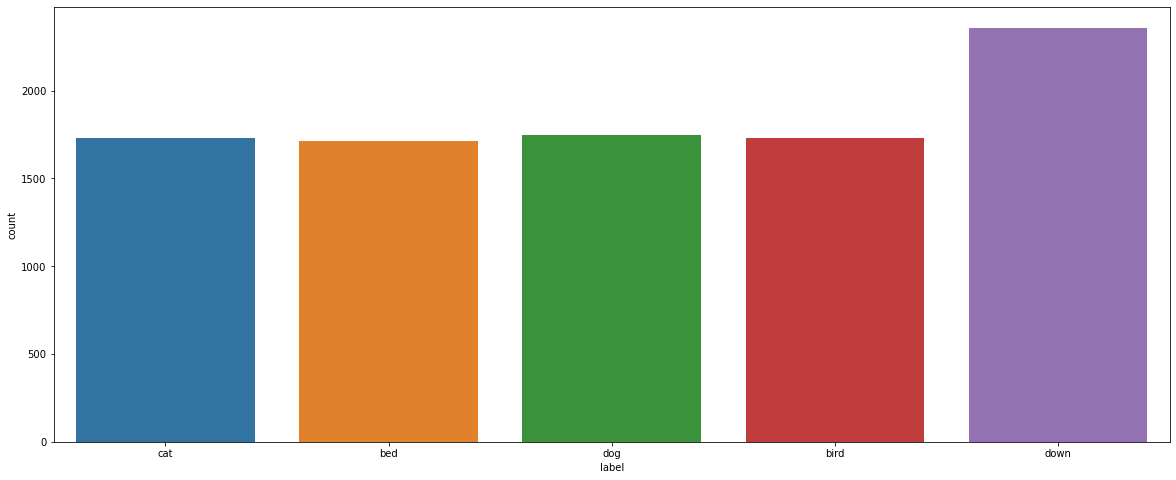

In [ ]:
# Extracting the entire data in a variable and then converting it to dataframe
import seaborn as sns
from scipy.io import wavfile
new_sample_rate = 16000

train_labels = []
train_samples = []
original_samples = []

# Loading all the waves and labels
for labels in os.listdir(train_audio_path):
    if labels == '_background_noise_' or labels == '.DS_Store':  #Removing background noise and .DS_Store file(Mac hidden file)
        continue
    for wav_file in os.listdir(os.path.join(train_audio_path, labels)):
        if wav_file[-4:] != '.wav':
            continue
        sample_rate, sample = wavfile.read(os.path.join(os.path.join(train_audio_path, labels), wav_file))
        #samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000) - Loading can be done using librosa library too
        samples = pad_audio(sample)   # Pad samples less than reference sample_rate(sr)
        if len(samples) > 16000:
            n_samples = chop_audio(samples) # Chopping the samples greater than reference sample_rate(sr)
        else: n_samples = [samples]

        for samples in n_samples:
            resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0])) #resampling can also be done using Librosa library
            _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
            train_labels.append(labels)
            train_samples.append(specgram)

        original_samples.append(sample)  #Appending the original sample for Visualization
        
df_train = pd.DataFrame({'audio_sample':train_samples,'label':train_labels})
fig, axis = plt.subplots(figsize=(20, 8))
sns.countplot(ax=axis, x="label", data=df_train)
print(df_train.label.unique())
print(df_train.head())

(array([  17.,   11.,   16.,   26.,  103.,   84.,  181.,  147.,  274.,
        8423.]),
 array([0.4644375 , 0.51799375, 0.57155   , 0.62510625, 0.6786625 ,
        0.73221875, 0.785775  , 0.83933125, 0.8928875 , 0.94644375,
        1.        ]),
 <BarContainer object of 10 artists>)

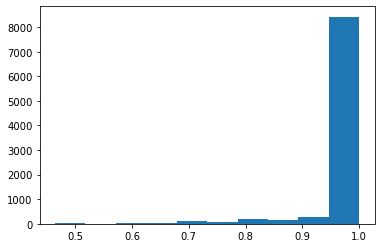

In [ ]:
# Distribution of duration of recordings

unique_labels = np.unique(train_labels)
duration_of_recordings=[]
for label in unique_labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

- Here is how the Bed utterance looks like after a 512 point FFT operation on windowed signal and applying a Hanning window with size 20 and overlap of 10 samples which would be explained more later.

Text(0.5, 0, 'Seconds')

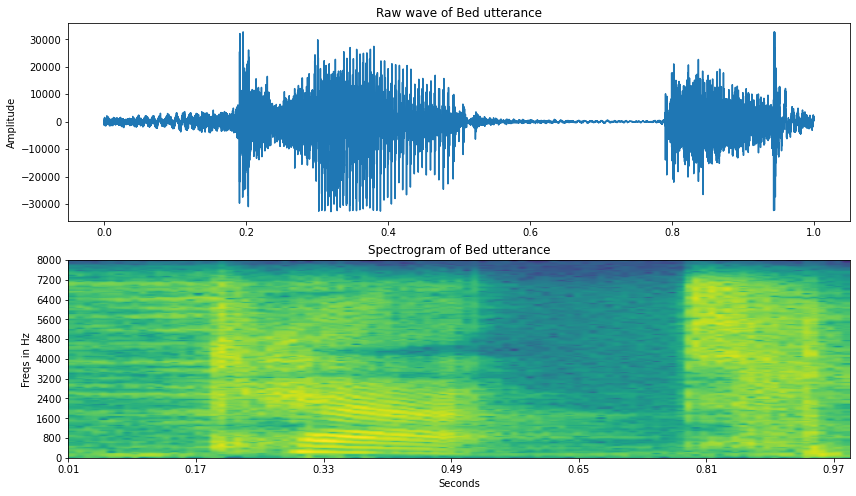

In [ ]:
# Spectrogram of Voices

freqs, times, spectrogram = log_specgram(original_samples[0], sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of Bed utterance')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(original_samples[0]), sample_rate), original_samples[0])
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Bed utterance')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

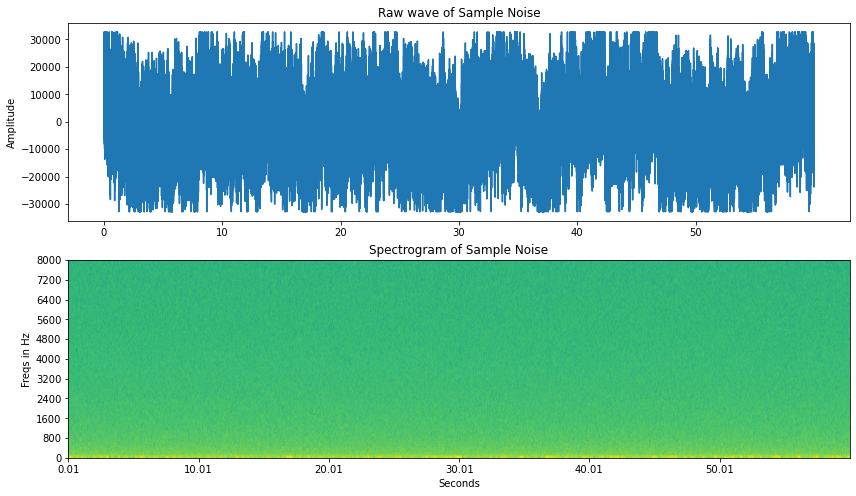

In [ ]:
# Spectrogram of noises

noise_directory = train_audio_path + '/_background_noise_'
noise_samples = []
for noises in os.listdir(noise_directory):
    if noises[-4:] != '.wav':
        continue
    noise_sample_rate, noise_sample = wavfile.read(os.path.join(noise_directory, noises))
    #noise_resampled = librosa.resample(noise_sample.astype(np.float), orig_sr=noise_sample_rate, target_sr=sample_rate)
    noise_resampled = noise_sample
    noise_samples.append(noise_resampled)

freqs, times, spectrogram = log_specgram(noise_samples[0], sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of Sample Noise')
ax1.set_ylabel('Amplitude')
x = np.linspace(0, len(noise_samples[0])/ sample_rate, len(noise_samples[0]))
ax1.plot(x, noise_samples[0])
ax1.set_xticks(np.arange(0, len(x)/ sample_rate , 10))
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::1000])
ax2.set_title('Spectrogram of Sample Noise')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
plt.show()

#### Conversion of labels from category to number

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(df_train['label'])
classes= list(le.classes_)
classes

['bed', 'bird', 'cat', 'dog', 'down']

In [ ]:
from keras.utils import np_utils
y_cat=np_utils.to_categorical(y, num_classes=len(unique_labels))
y_cat

Using TensorFlow backend.


array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_cat.shape

(9282, 5)

In [ ]:
X = np.array(train_samples)
X.shape

(9282, 99, 161)

In [ ]:
# Train-Test Split

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05)

#### Model Development

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def build_RNN_model():
    inputs = Input(name='inputs', shape=(99, 161))
    layer = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Dense(64, name='FC1', activation='relu')(layer)
    layer = Dense(32, name='FC2', activation='relu')(layer)
    layer = Dense(16, name='FC3', activation='relu')(layer)
    layer = Dense(len(classes), name='out_layer', activation='softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = build_RNN_model()

2022-07-05 13:15:57.073056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 99, 161)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 99, 256)           296960    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
FC1 (Dense)                  (None, 64)                8256      
_________________________________________________________________
FC2 (Dense)                  (None, 32)                2080      
_________________________________________________________________
FC3 (Dense)                  (None, 16)                528       
_________________________________________________________________
out_layer (Dense)            (None, 5)                 85    

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(X_val, y_val))
                    #callbacks=[EarlyStopping(monitor='val_accuracy',
                                             #patience=3)])

2022-07-05 13:15:59.713798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
111/111 [==============================] - 34s 268ms/step - loss: 1.5283 - accuracy: 0.2885 - val_loss: 1.2187 - val_accuracy: 0.5460
Epoch 2/20
111/111 [==============================] - 37s 335ms/step - loss: 1.0848 - accuracy: 0.5557 - val_loss: 0.8044 - val_accuracy: 0.6979
Epoch 3/20
111/111 [==============================] - 46s 416ms/step - loss: 0.7213 - accuracy: 0.7247 - val_loss: 0.5564 - val_accuracy: 0.8045
Epoch 4/20
111/111 [==============================] - 37s 338ms/step - loss: 0.5075 - accuracy: 0.8162 - val_loss: 0.6527 - val_accuracy: 0.7652
Epoch 5/20
111/111 [==============================] - 39s 351ms/step - loss: 0.4154 - accuracy: 0.8457 - val_loss: 0.4167 - val_accuracy: 0.8546
Epoch 6/20
111/111 [==============================] - 36s 328ms/step - loss: 0.3151 - accuracy: 0.8938 - val_loss: 0.3124 - val_accuracy: 0.8912
Epoch 7/20
111/111 [==============================] - 40s 361ms/step - loss: 0.2553 - accuracy: 0.9129 - val_loss: 0.3184 - val_ac

Text(0.5, 1.0, 'Training and validation loss')

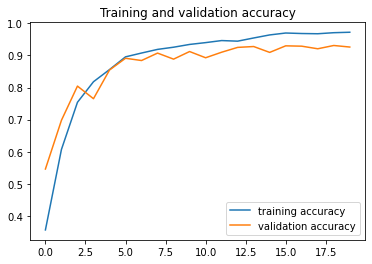

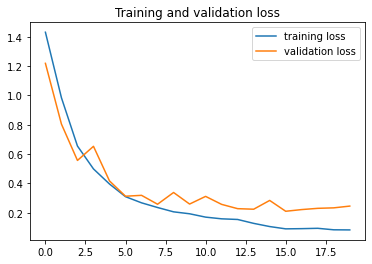

In [ ]:
## Accuracy and Loss plots

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [ ]:
model.save('model_lstm_final.h5')
model.save_weights('model_lstm_weights_final.h5')

In [ ]:
from tensorflow.keras.models import load_model
speech_model = load_model('model_lstm_final.h5')

In [ ]:
X_test.shape

(372, 99, 161)

Actual_Label: cat
Softmax Outputs: [[8.4005642e-06 5.8366606e-07 9.9979633e-01 5.8865415e-05 1.3591911e-04]]
1.0000001
Predicted_Label: cat


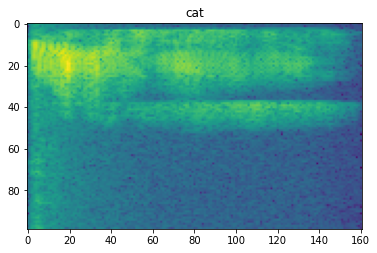

In [ ]:
# Predicting the test audio

import matplotlib.pyplot as plt
%matplotlib inline

n = 15

# Print the actual label

for i, j in enumerate(y_test[n]):
    if j == y_test[n].max():
        print('Actual_Label:', classes[i])
        plt.title(classes[i])
        plt.imshow(X_test[n])


# predicting the test speech
y_pred = speech_model.predict(X_test[n].reshape(-1, 99, 161))
print("Softmax Outputs:", y_pred)
print(y_pred.sum())


# Convert the predicted probabilities to labels

for i in y_pred:
    for j, k in enumerate(i):
        if k == y_pred.max():
            print('Predicted_Label:', classes[j])

### Further Imporvements
- This is just an introduction to speech recognition using simple RNN model.
- Adding dropouts can reduce overfitting
- The model can be trained using Convolution layers too.
- Futher with the application of Mel Scaled Log Filter Banks(MS-LFB) features the speech recognition models can be trained better. 